# Overview

Here we are simply trying to minimize the root mean square error for predicting the 50th percentile [O/H] from SDSS spectroscopy. Everything in this notebook follows from the previous one.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class

In [4]:
@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's try to see how well we can do with resnet34

In [11]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [32]:
sz = 64
bs = 128
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

In [33]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [34]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 90%|█████████ | 1083/1200 [01:03<00:06, 17.08it/s, loss=2.29] 

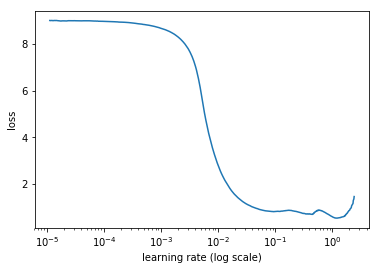

In [17]:
learn.lr_find()
learn.sched.plot()

# Begin training

## Start with size 64x64 and batch size of 512
A learning rate of 0.1 works better initially, although this will need to be annealed later.

In [35]:
lr = 0.1
learn.fit(lr, n_cycle=1, cycle_len=3)

epoch      trn_loss   val_loss                                 
    0      0.164546   0.154732  
    1      0.153928   0.143939                                 
    2      0.150324   0.142174                                 


[array([0.14217])]

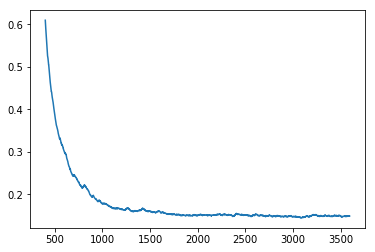

In [36]:
learn.sched.plot_loss(n_skip=400)

In [37]:
learn.save('resnet34-sz64-bs512_init')

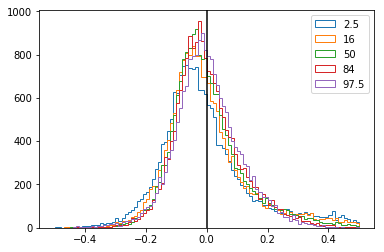

In [38]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');


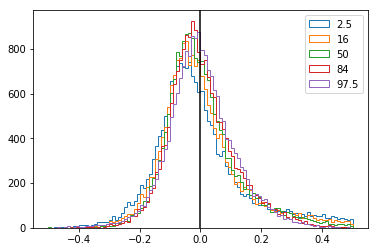

In [39]:

for i in range(5):
    plt.hist(np.median(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');

In [40]:
np.sqrt(np.mean((np.mean(p_val, axis=0) - y_val)**2, axis=0))

array([0.17492, 0.14817, 0.12485, 0.11181, 0.11065], dtype=float32)

In [41]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.147557   0.141935  
    1      0.151561   0.140925                                 
    2      0.147716   0.140691                                 
    3      0.151943   0.140108                                 
    4      0.144979   0.141474                                 
    5      0.144399   0.139348                                 
    6      0.14616    0.139638                                 


[array([0.13964])]

Histograms show that network is seriously underfitting; predictions are consistently too low for predicting [O/H].

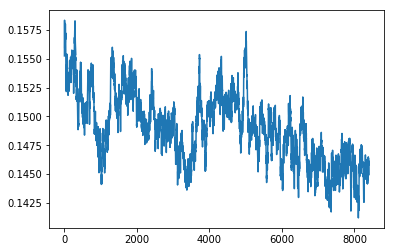

In [42]:
learn.sched.plot_loss()

In [43]:
learn.save('resnet34-sz64-bs512_init-2')

## Unfreeze early layers

### Begin differential learning with lr=0.1

In [44]:
learn.unfreeze()
lrs = 0.1 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.107797   0.100913  
    1      0.110098   0.10905                                  
    2      0.103186   0.097004                                 
    3      0.110328   0.099826                                 
    4      0.10665    0.101612                                 
    5      0.102421   0.095024                                 
    6      0.098916   0.094423                                  


[array([0.09442])]

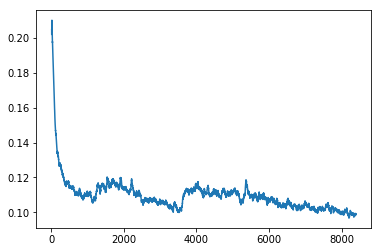

In [45]:
learn.sched.plot_loss()

In [54]:
#learn.save('resnet34-sz64-bs512_diff-1')
#learn.load('resnet34-sz64-bs512_diff-1')

### Continue training with annealed learning rate

In [55]:
lrs = 3e-3 * np.array([1/9, 1/3, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.100215   0.095078  
    1      0.100558   0.096375                                  
    2      0.100946   0.095957                                  
    3      0.099852   0.095259                                  
    4      0.099734   0.094698                                  
    5      0.098406   0.094201                                  
    6      0.099084   0.095213                                  


[array([0.09521])]

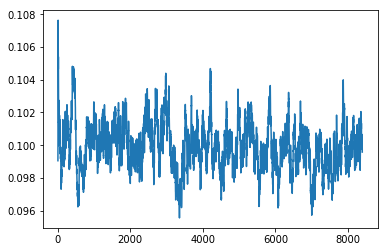

In [56]:
learn.sched.plot_loss()

In [57]:
learn.save('resnet34-sz64-bs512_diff-2')

### Anneal even further

In [58]:
lrs = 1e-3 * np.array([1/9, 1/3, 1])
learn.fit(lrs, 2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.10126    0.094679  
    1      0.099107   0.094726                                  
    2      0.100044   0.095027                                  
    3      0.097005   0.094745                                  
    4      0.100315   0.094747                                  
    5      0.098299   0.094613                                  


[array([0.09461])]

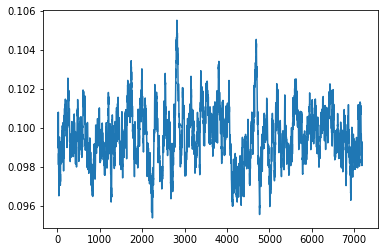

In [59]:
learn.sched.plot_loss()

In [60]:
learn.save('resnet34-sz64-bs512_diff-3')

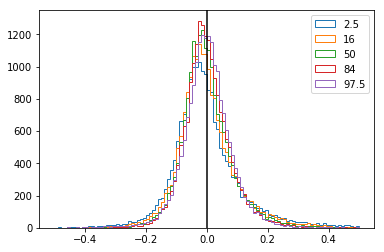

In [61]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.axvline(0, c='k');

These last few cycles didn't seem to do much...

## Size up to 128x128
Let's re-freeze + train some

In [64]:
data = get_data(128, 512)
learn.set_data(data)

epoch      trn_loss   val_loss                                 
    0      0.151915   0.142966  
    1      0.140218   0.129269                                 
    2      0.136194   0.125387                                 


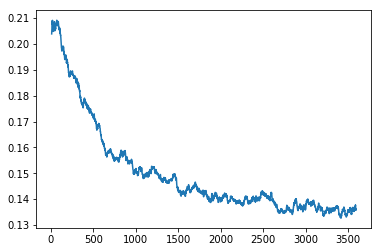

In [62]:
learn.freeze()

lr = 3e-3
learn.fit(lr, 3, cycle_len=1)
learn.sched.plot_loss()

Unfreeze and train more

In [65]:
learn.unfreeze()

lrs = 1e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.122911   0.11241   
    1      0.11435    0.107623                                 
    2      0.114057   0.107326                                 
    3      0.113983   0.106329                                 
    4      0.111348   0.104331                                 
    5      0.108963   0.103545                                 
    6      0.110523   0.103569                                 


[array([0.10357])]

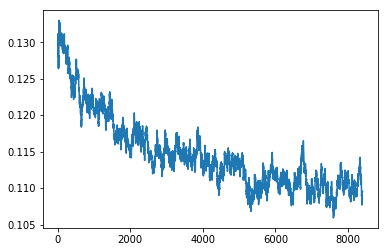

In [66]:
learn.sched.plot_loss()

In [ ]:
learn.save('resnet34-sz64,128-bs512_diff-1')

In [67]:
lrs = 1e-3 * np.array([1e-2, 1e-1, 1])

learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                                 
    0      0.11139    0.105301  
    1      0.110726   0.1032                                   


[array([0.1032])]

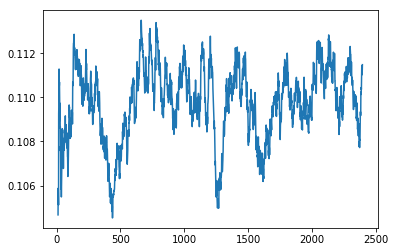

In [68]:
learn.sched.plot_loss()

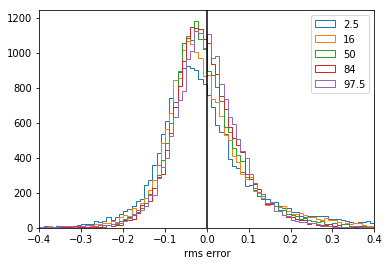

In [105]:
p_val, y_val = learn.TTA()

for i in range(5):
    plt.hist(np.mean(p_val, axis=0)[:, i]-y_val[:, i], bins=100, histtype='step', range=[-0.5, 0.5]);
plt.legend(['2.5', '16', '50', '84', '97.5']);
plt.xlim(-0.4, 0.4)
plt.axvline(0, c='k')
plt.xlabel('rms error');